# CS:GO anti-cheat
## Kfir Back 325345064
### Creating an anti-cheat for a game that doesn't have one.

**Libraries**

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import MiniBatchKMeans
import networkx as nx
from scipy.stats import ks_2samp
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

**Loading the data**

In [ ]:
# define dataset path
dataset_path = "./CSGO_Cheating_Dataset"

# create full paths for cheaters and legit data
cheaters_npy = os.path.join(dataset_path, "cheaters.npy")
legit_npy = os.path.join(dataset_path, "legit.npy")

# load the numpy arrays
cheaters = np.load(cheaters_npy)
legit = np.load(legit_npy)

# combine cheaters and legit data into one dataset
data = np.concatenate([cheaters, legit], axis=0)

# create labels, 1 for cheaters and 0 for legit
labels = np.concatenate([
    np.ones(cheaters.shape[0], dtype=np.int32),
    np.zeros(legit.shape[0], dtype=np.int32)
], axis=0)

# print data and label shapes
print("data shape:", data.shape)
print("labels shape:", labels.shape)

# split data into train and test sets with stratification
train_idx, test_idx = train_test_split(
    np.arange(data.shape[0]), test_size=0.2, random_state=42, shuffle=True, stratify=labels
)

# create training and testing datasets with labels
training = data[train_idx]
training_labels = labels[train_idx]

test = data[test_idx]
test_labels = labels[test_idx]

# print shapes of training and testing sets
print("training shape:", training.shape)
print("training labels shape:", training_labels.shape)
print("test shape:", test.shape)
print("test labels shape:", test_labels.shape)


Data shape: (12000, 30, 192, 5)
Labels shape: (12000,)
Training shape: (9600, 30, 192, 5)
Training labels shape: (9600,)
Test shape: (2400, 30, 192, 5)
Test labels shape: (2400,)


***Meta data***

In [ ]:
# check for missing values and outliers in the combined dataset
print('Checking for missing values:')
print(np.isnan(data).sum(), 'missing values')

# check for extreme values using IQR for each feature
print('\nOutlier detection using IQR (per feature):')
num_features = data.shape[-1] if data.ndim == 4 else data.shape[1]
flat_data = data.reshape(-1, num_features)
for i in range(num_features):
    col = flat_data[:, i]
    Q1 = np.percentile(col, 0.01)
    Q3 = np.percentile(col, 99.99)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (col < lower) | (col > upper)
    outliers = np.sum(mask)
    
    if outliers > 0:
        example = col[mask][0]
        print(f"Feature {i}: {outliers} outliers, example: {example}")
    else:
        print(f"Feature {i}: {outliers} outliers")


Checking for missing values:
0 missing values

Outlier detection using IQR (per feature):
Feature 0: 0 outliers
Feature 1: 341 outliers, example: 87.94599914550781
Feature 2: 0 outliers
Feature 3: 0 outliers
Feature 4: 0 outliers


The outLiers in feature 1 (Attacker delta pitch) is still reasonble so I don't have to delete it.

**Initial Display**

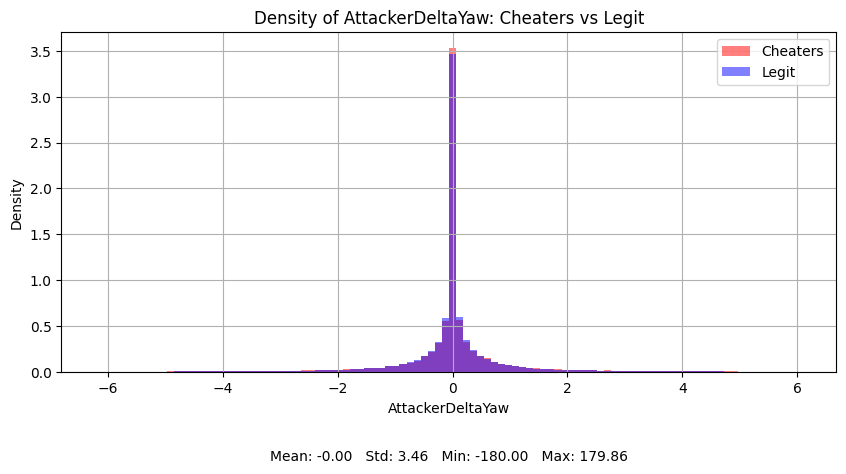

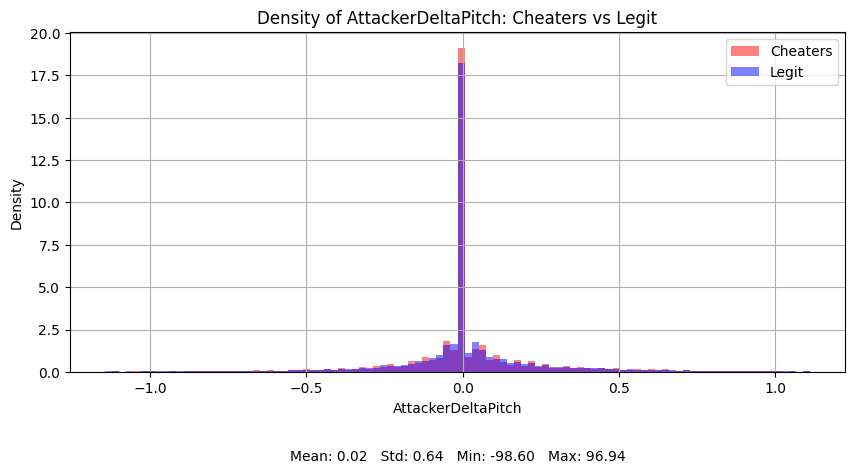

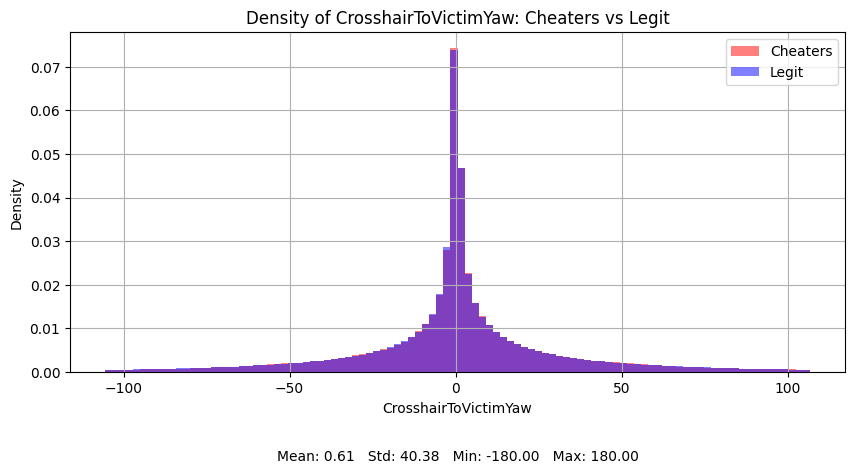

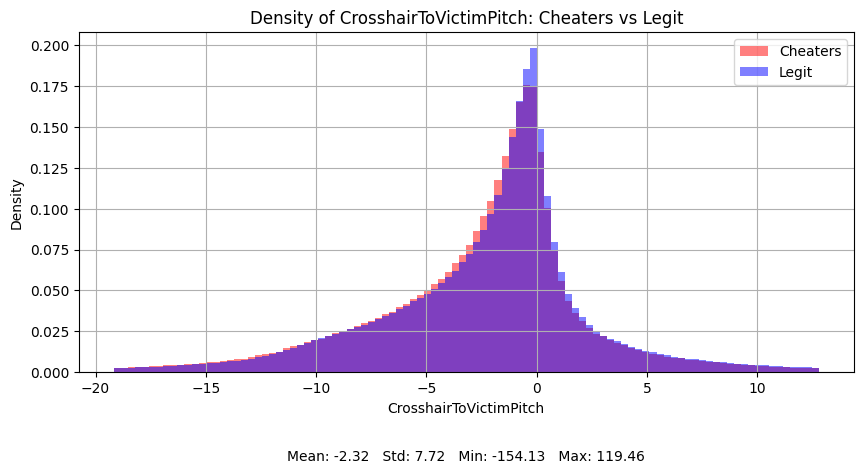

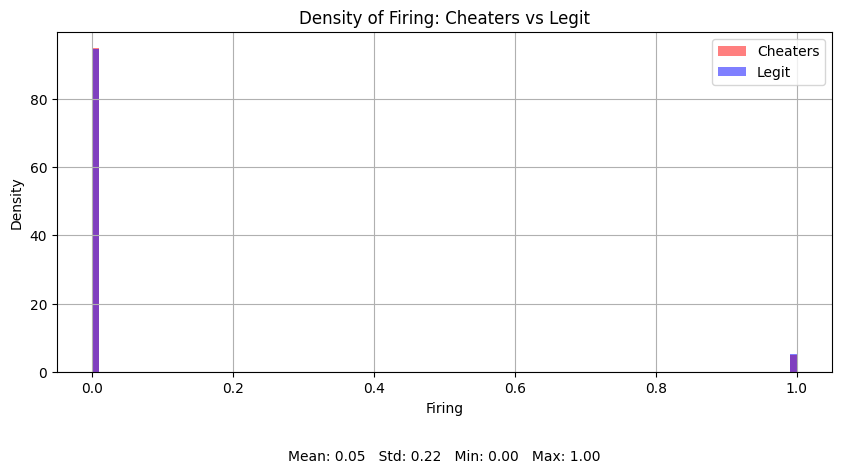

In [ ]:
def show_data(arr, labels_arr):
    feature_indices = {
        'AttackerDeltaYaw': 0,
        'AttackerDeltaPitch': 1,
        'CrosshairToVictimYaw': 2,
        'CrosshairToVictimPitch': 3,
        "Firing" : 4
    }

    matches, players, ticks, features = arr.shape
    arr_flat = arr.reshape(-1, features)  # (matches * players * ticks, features)
    labels_per_entry = np.repeat(labels_arr, players * ticks)

    for feature_name, idx in feature_indices.items():
        plt.figure(figsize=(10, 5))

        cheaters_data = arr_flat[labels_per_entry == 1, idx]
        legit_data = arr_flat[labels_per_entry == 0, idx]

        lower = np.percentile(arr_flat[:, idx], 2)
        upper = np.percentile(arr_flat[:, idx], 98)

        plt.hist(cheaters_data, bins=100, range=(lower, upper), density=True, alpha=0.5, color='red', label='Cheaters')
        plt.hist(legit_data, bins=100, range=(lower, upper), density=True, alpha=0.5, color='blue', label='Legit')

        plt.title(f"Density of {feature_name}: Cheaters vs Legit")
        plt.xlabel(feature_name)
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)

        # compute stats
        stats_text = (
            f"Mean: {arr_flat[:, idx].mean():.2f}   "
            f"Std: {arr_flat[:, idx].std():.2f}   "
            f"Min: {arr_flat[:, idx].min():.2f}   "
            f"Max: {arr_flat[:, idx].max():.2f}"
        )

        # add stats below plot
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.text(0.5, -0.25, stats_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

        plt.show()
show_data(data, labels)

These graph tell us almost nothing, because we need to also add the timestamp aspect.

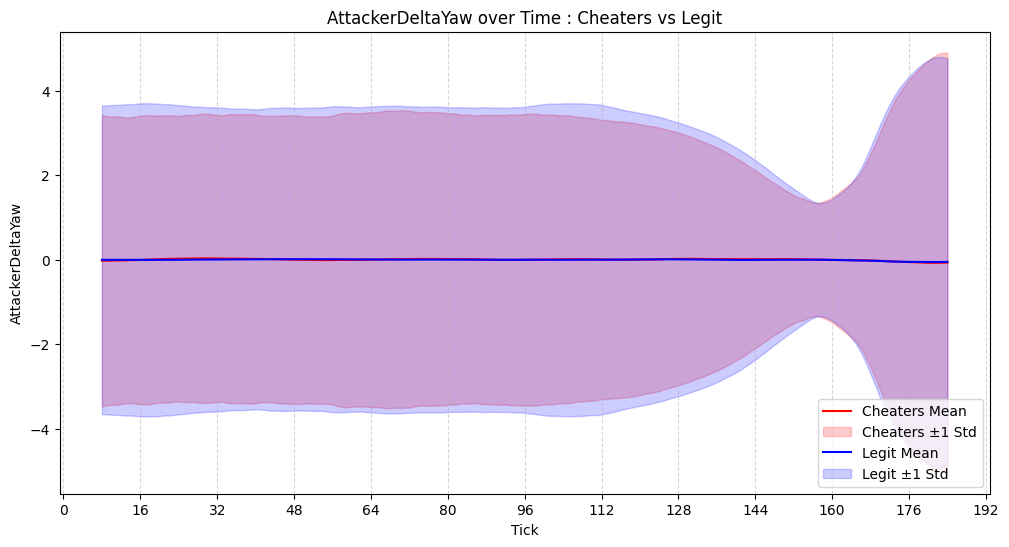

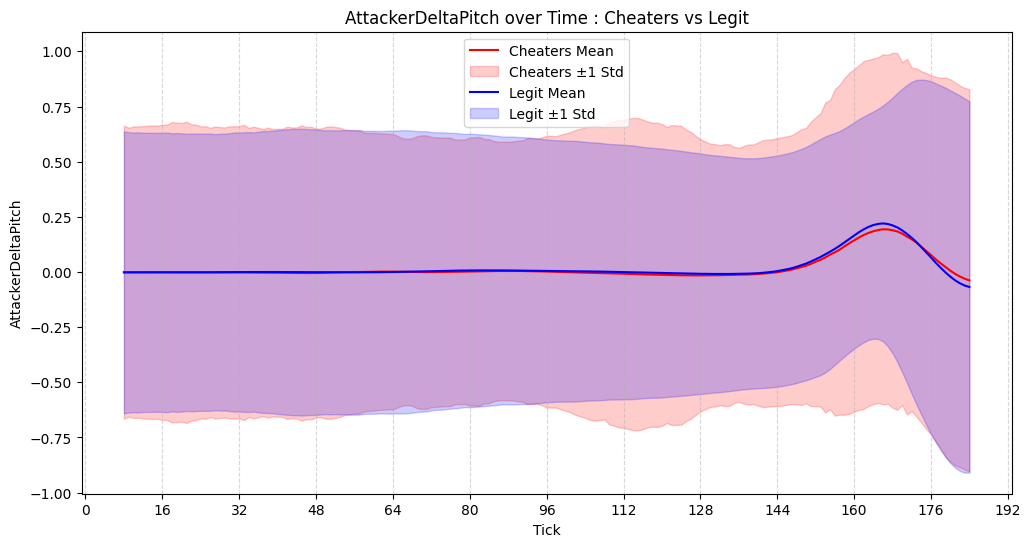

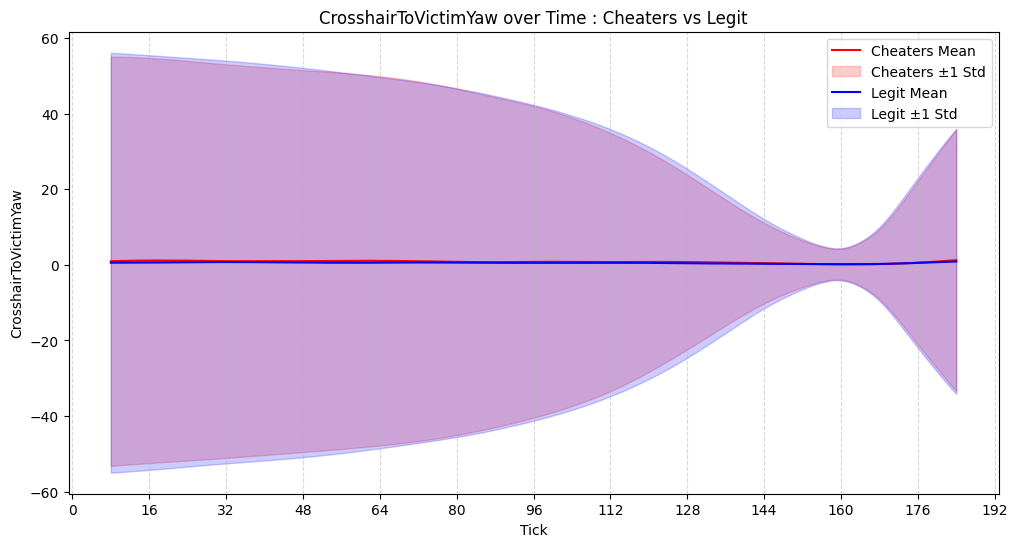

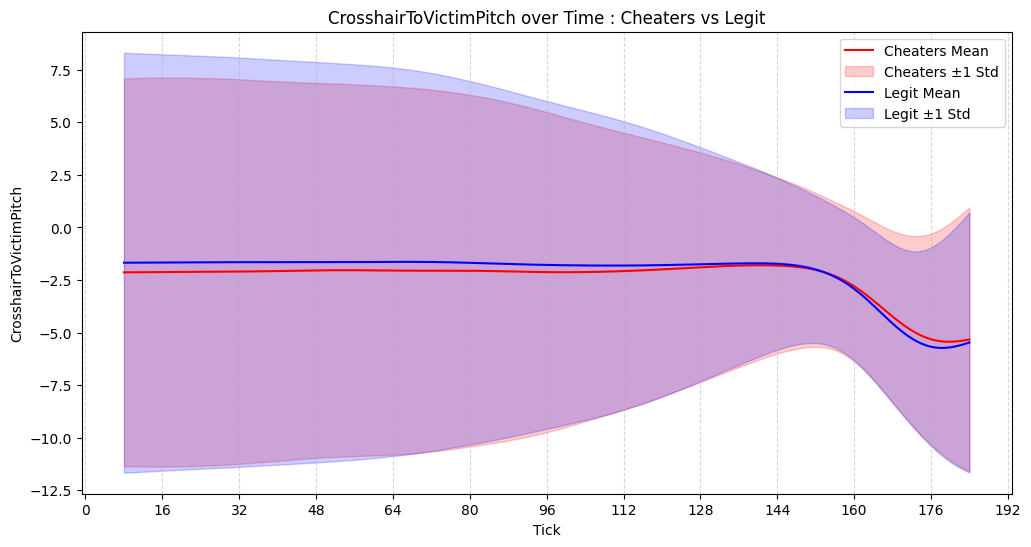

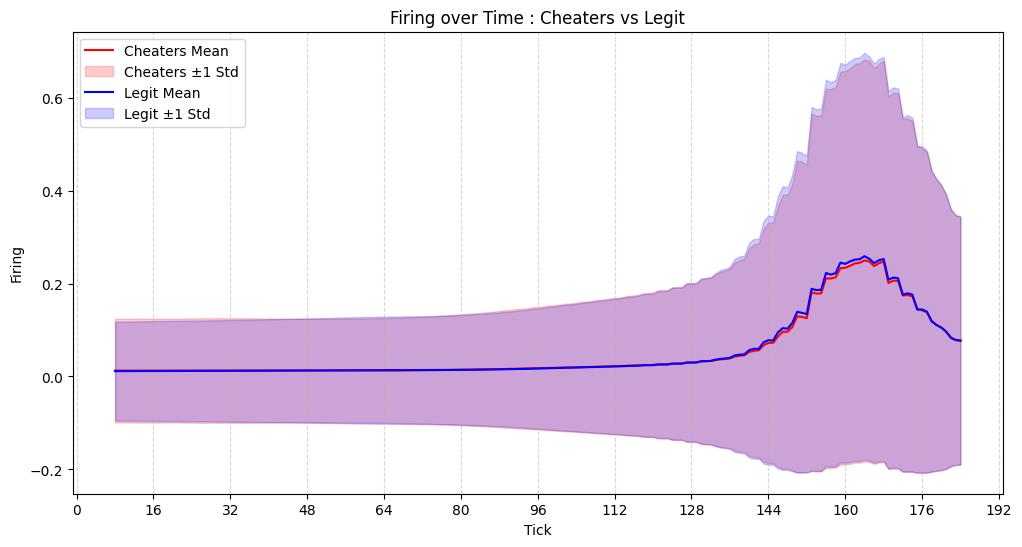

In [ ]:
# function to plot feature data over time for cheaters and legit players
def show_data_over_time(arr, labels_arr, window_size=16):
    # define feature indices for easier access
    feature_indices = {
        'attacker_delta_yaw': 0,
        'attacker_delta_pitch': 1,
        'crosshair_to_victim_yaw': 2,
        'crosshair_to_victim_pitch': 3,
        'firing': 4
    }

    # extract dimensions from the dataset
    matches, players, ticks, features = arr.shape

    # flatten data for easier handling
    arr_flat = arr.reshape(-1, features)

    # repeat labels for each player and tick
    labels_per_entry = np.repeat(labels_arr, players * ticks)

    # create timestamps for plotting
    timestamps = np.tile(np.arange(ticks), matches * players)

    # iterate through each feature and plot
    for feature_name, idx in feature_indices.items():
        plt.figure(figsize=(12, 6))

        # plot for cheaters (1) and legit (0) with separate colors
        for label_value, color, label_name in zip([1, 0], ['red', 'blue'], ['cheaters', 'legit']):
            mask = labels_per_entry == label_value
            feature_values = arr_flat[mask, idx]
            time_values = timestamps[mask]

            means = []
            stds = []
            centers = []

            # compute mean and standard deviation over sliding windows
            for t in range(0, ticks - window_size + 1):
                mask_window = (time_values >= t) & (time_values < t + window_size)
                if np.any(mask_window):
                    means.append(feature_values[mask_window].mean())
                    stds.append(feature_values[mask_window].std())
                    centers.append(t + window_size / 2)

            means = np.array(means)
            stds = np.array(stds)
            centers = np.array(centers)

            # plot mean values and shaded standard deviation region
            plt.plot(centers, means, color=color, label=f"{label_name} mean")
            plt.fill_between(centers, means - stds, means + stds, color=color, alpha=0.2, label=f"{label_name} ±1 std")

        # configure plot appearance
        plt.title(f"{feature_name} over time: cheaters vs legit")
        plt.xlabel("tick")
        plt.ylabel(feature_name)
        plt.xticks(np.arange(0, 193, 16))
        plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
        plt.legend()
        plt.show()

show_data_over_time(training, training_labels)


First thing we can notice is that the pitch of the cheaters is generally lower than the legit players before shooting, because they don't have to aim as well as non cheaters (Default should be 0, but players tend to walk looking a bit down, so that if they dont hit the head they still hit the body). <br>
To add to that we can notice that the cheaters pitch after shooting is higher, that may be because their cheats know how to compensate for recoil better.

***Calculating the correlation***

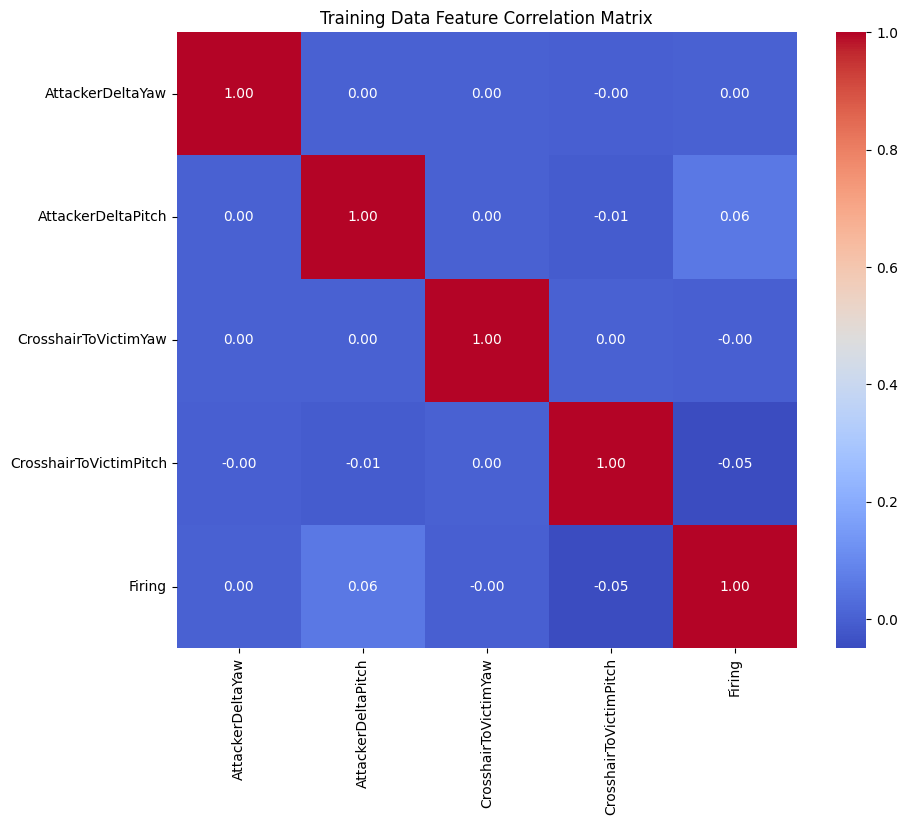

In [6]:
matches, players, ticks, features = training.shape
flat_training = training.reshape(-1, features)


feature_names = ['AttackerDeltaYaw','AttackerDeltaPitch','CrosshairToVictimYaw','CrosshairToVictimPitch', "Firing"]


df_train = pd.DataFrame(flat_training, columns=feature_names)

corr_matrix = df_train.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Training Data Feature Correlation Matrix")
plt.show()

There is no need for a dimention change, because the correlation matrix indicates that the features aren't related.

***Abnormality detection***

I chose to use Isolation Forest

In [7]:

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(flat_training)


preds = model.predict(flat_training)
anomalies = (preds == -1)

print(f"Detected {anomalies.sum()} anomalies out of {len(anomalies)} samples")

Detected 552958 anomalies out of 55296000 samples


Seeing I don't want to remove any of them, I will add a feature that will act as weight.

In [8]:
scores = model.decision_function(flat_training)
df_train['anomaly_score'] = scores

***Clustering with K-means***

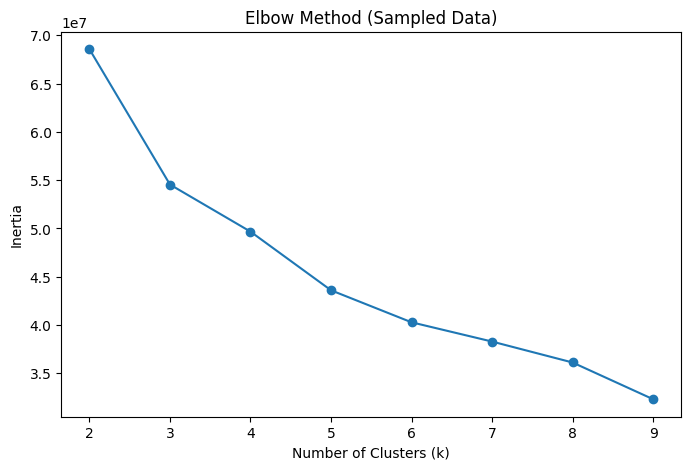

Best number of clusters (Elbow): 3


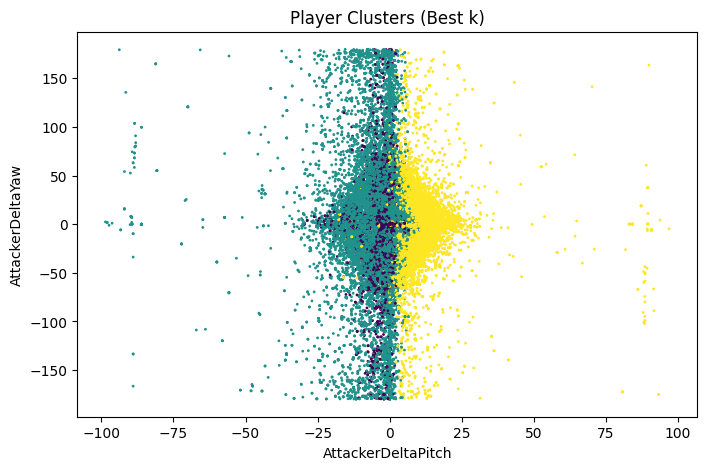

In [ ]:
# get shape of training data
matches, players, ticks, features = training.shape

# add time column to dataframe if it does not exist
if 'time' not in df_train.columns:
    df_train['time'] = np.tile(np.arange(ticks), matches * players)

# select feature columns for clustering
feature_cols = [
    'attacker_delta_yaw', 'attacker_delta_pitch',
    'crosshair_to_victim_yaw', 'crosshair_to_victim_pitch',
    'firing', 'time', 'anomaly_score'
]

# extract features from dataframe
X = df_train[feature_cols]

# scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# sample 20 percent of data for faster testing
sample_frac = 0.2
idx = np.random.choice(X_scaled.shape[0], int(X_scaled.shape[0] * sample_frac), replace=False)
X_sample = X_scaled[idx]

# test inertia for different cluster counts
k_values = range(2, 10)
inertia = []

for k in k_values:
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        random_state=42,
        n_init='auto'
    )
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

# plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("elbow method sampled data")
plt.xlabel("number of clusters k")
plt.ylabel("inertia")
plt.show()

# pick best k using elbow heuristic
diffs = np.diff(inertia)
best_k = k_values[np.argmin(diffs) + 1]
print(f"best number of clusters elbow: {best_k}")

# fit final minibatch kmeans on full dataset
final_kmeans = MiniBatchKMeans(
    n_clusters=best_k,
    batch_size=2048,
    random_state=42,
    n_init='auto'
)
df_train['cluster'] = final_kmeans.fit_predict(X_scaled)

# plot clusters
plt.figure(figsize=(8, 5))
plt.scatter(df_train['attacker_delta_pitch'], df_train['attacker_delta_yaw'],
            c=df_train['cluster'], cmap='viridis', s=1)
plt.title("player clusters best k")
plt.xlabel("attacker delta pitch")
plt.ylabel("attacker delta yaw")
plt.show()


***Segment analysis***

In [ ]:
# get dimensions of training data
matches, players, ticks, features = training.shape

# add true labels column to dataframe by repeating labels for each player and tick
df_train['true_label'] = training_labels.repeat(players * ticks)

# list of features to analyze
feature_cols = [
    'attacker_delta_yaw', 'attacker_delta_pitch',
    'crosshair_to_victim_yaw', 'crosshair_to_victim_pitch',
    'firing'
]

# store analysis results for each feature
results = []

# perform kolmogorov smirnov test for each feature
for feature in feature_cols:
    cheaters = df_train[df_train['true_label'] == 1][feature]
    legit = df_train[df_train['true_label'] == 0][feature]
    ks_stat, ks_p = ks_2samp(cheaters, legit)

    results.append({
        'feature': feature,
        'mean_cheater': cheaters.mean(),
        'mean_legit': legit.mean(),
        'var_cheater': cheaters.var(),
        'var_legit': legit.var(),
        'ks_statistic': ks_stat,
        'ks_p_value': ks_p
    })

# create dataframe summarizing feature analysis
feature_summary = pd.DataFrame(results)

# create temporal summary of features grouped by time and true label
temporal_summary = df_train.groupby(['time', 'true_label'])[feature_cols].mean().reset_index()

# display summaries
display(feature_summary)
display(temporal_summary)


,Feature,Mean_Cheater,Mean_Legit,Var_Cheater,Var_Legit,KS_Statistic,KS_p_value
0,AttackerDeltaYaw,-0.002438,-0.004453,11.098929,12.174734,0.007400,0.000000e+00
1,AttackerDeltaPitch,0.013873,0.016466,0.460959,0.392917,0.017425,0.000000e+00
2,CrosshairToVictimYaw,0.797354,0.532263,1573.986816,1639.129272,0.004202,3.241772e-118
3,CrosshairToVictimPitch,-2.502735,-2.281507,55.091679,60.466938,0.030212,0.000000e+00
4,Firing,0.051068,0.052132,0.048460,0.049414,0.001064,5.620031e-08


,time,true_label,AttackerDeltaYaw,AttackerDeltaPitch,CrosshairToVictimYaw,CrosshairToVictimPitch,Firing
0,0,0,-0.012351,-0.002697,0.493144,-1.690749,0.011542
1,0,1,-0.034931,-0.000858,0.693470,-2.150499,0.013146
2,1,0,-0.008077,-0.003010,0.547010,-1.687454,0.011100
3,1,1,-0.029474,-0.003920,0.720721,-2.146143,0.011354
4,2,0,-0.009639,-0.003012,0.558495,-1.686578,0.011608
...,...,...,...,...,...,...,...
379,189,1,-0.024145,-0.053119,1.674743,-5.014971,0.069396
380,190,0,-0.020741,-0.060148,1.023718,-4.927464,0.020892
381,190,1,-0.008533,-0.046284,1.714697,-4.963675,0.021875
382,191,0,-0.016232,-0.050678,1.072925,-4.869421,0.032242


The KS test results indicate that all features significantly differ between the two groups (p-values close to 0), meaning their distributions are not the same. Notably, CrosshairToVictimYaw and CrosshairToVictimPitch exhibit large mean differences and very high variances compared to other features, suggesting these are strong indicators for distinguishing cheaters. Temporal analysis further highlights how these feature values evolve over time for each label, showing that cheaters often maintain distinct patterns (e.g., higher yaw alignment and pitch adjustments) compared to legit players. This implies that these spatial aiming features are the most discriminative and could be prioritized or weighted more heavily in detection models to improve cheater identification.

***Graphs***

Information Graph

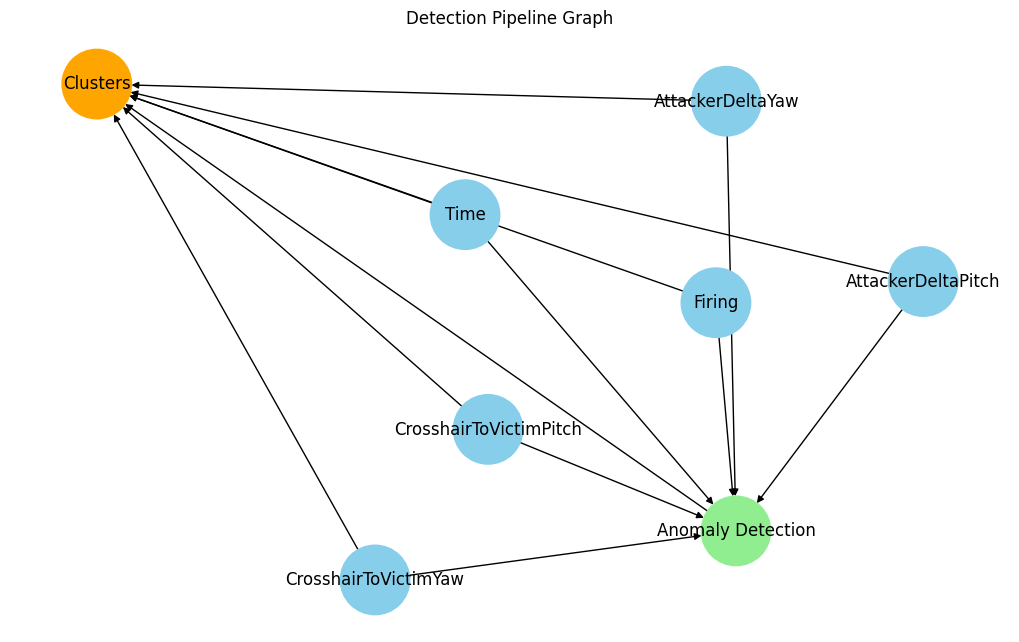

In [11]:

features = [
    "AttackerDeltaYaw", "AttackerDeltaPitch",
    "CrosshairToVictimYaw", "CrosshairToVictimPitch",
    "Firing", "Time"
]

nodes = features + ["Anomaly Detection", "Clusters"]
G = nx.DiGraph()
G.add_nodes_from(nodes)

# Connections
for f in features:
    G.add_edge(f, "Anomaly Detection")
    G.add_edge(f, "Clusters")
G.add_edge("Anomaly Detection", "Clusters")

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
colors = ['skyblue' if n in features else 'lightgreen' if n == 'Anomaly Detection' else 'orange' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=2500, node_color=colors, arrows=True)
plt.title("Detection Pipeline Graph")
plt.show()


Raw gameplay features flow into anomaly detection and directly into clustering.
Detected anomalies help refine player segmentation into distinct behavior groups.

Cluster Visualization

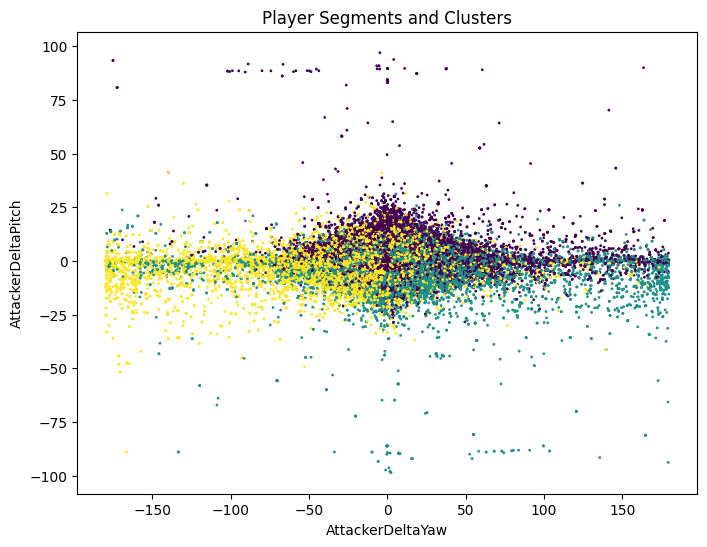

In [12]:

feature_cols = [
    'AttackerDeltaYaw', 'AttackerDeltaPitch',
    'CrosshairToVictimYaw', 'CrosshairToVictimPitch',
    'Firing', 'time'
]

X = df_train[feature_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = MiniBatchKMeans(n_clusters=3, batch_size=2048, random_state=42, n_init='auto')
df_train['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_train['AttackerDeltaYaw'], df_train['AttackerDeltaPitch'], 
            c=df_train['cluster'], cmap='viridis', s=1)
plt.title("Player Segments and Clusters")
plt.xlabel("AttackerDeltaYaw")
plt.ylabel("AttackerDeltaPitch")
plt.show()


Players are grouped into segments based on aiming behavior.
Clusters highlight distinct aiming patterns and potential cheating behavior.

Weak point Graph

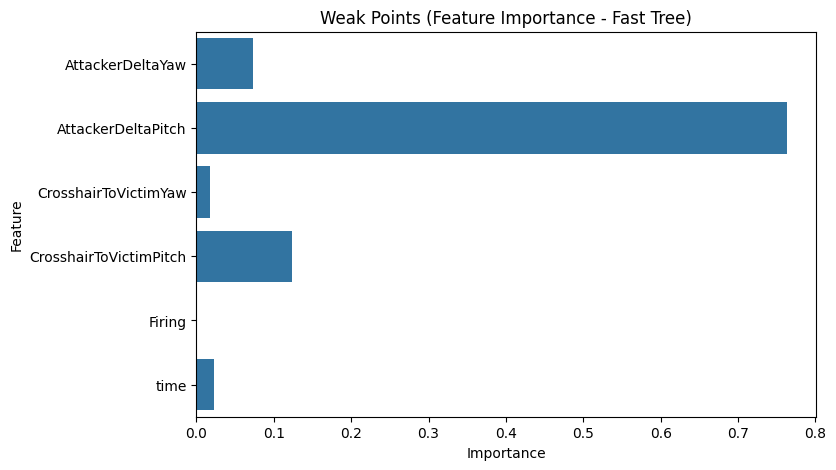

In [13]:

# Feature columns
feature_cols = [
    'AttackerDeltaYaw', 'AttackerDeltaPitch',
    'CrosshairToVictimYaw', 'CrosshairToVictimPitch',
    'Firing', 'time'
]

# Data
X_train = df_train[feature_cols]
y_train = df_train['true_label']

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Train a small decision tree
tree = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
tree.fit(X_scaled, y_train)

# Plot importance
importances = tree.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_cols)
plt.title("Weak Points (Feature Importance - Fast Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Feature importance analysis shows that vertical aiming adjustments (AttackerDeltaPitch) are the dominant factor in cheat detection, with CrosshairToVictimPitch also contributing. Other features, including horizontal aim and firing rate, have minimal impact

***Model***

Epoch 5/35, Loss: 0.3946
Epoch 10/35, Loss: 0.2387
Epoch 15/35, Loss: 0.1259
Epoch 20/35, Loss: 0.0363
Epoch 25/35, Loss: 0.0069
Epoch 30/35, Loss: 0.0028
Epoch 35/35, Loss: 0.0034
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2000
           1       0.47      0.27      0.34       400

    accuracy                           0.83      2400
   macro avg       0.67      0.60      0.62      2400
weighted avg       0.80      0.83      0.81      2400



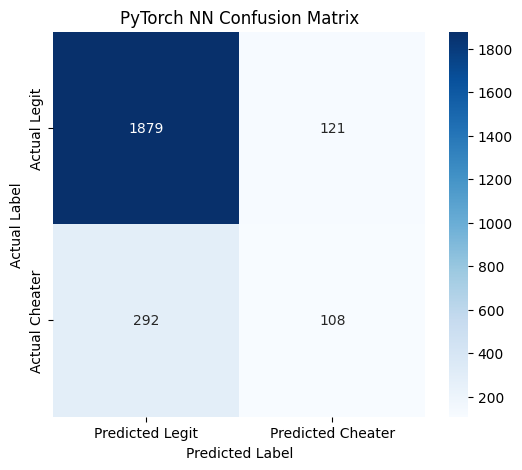

In [ ]:
# flatten time dimension to create a single feature vector per sample
def flatten_time(data):
    samples, players, ticks, features = data.shape
    return data.reshape(samples, players * ticks * features)

# prepare train and test sets
X_train = flatten_time(training)
X_test = flatten_time(test)
y_train = training_labels
y_test = test_labels

# scale data for neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# define neural network model for cheat detection
class CheatDetector(nn.Module):
    def __init__(self, input_size):
        super(CheatDetector, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

# initialize model, loss function and optimizer
model = CheatDetector(X_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train neural network
epochs = 35
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f'epoch {epoch+1}/{epochs}, loss: {loss.item():.4f}')

# predict probabilities and convert to binary labels
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy().flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# evaluate model performance
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['predicted legit', 'predicted cheater'],
            yticklabels=['actual legit', 'actual cheater'])

plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.title('pytorch nn confusion matrix')
plt.show()


The neural network achieved an overall accuracy of 83%, performing well at detecting legit players (94% recall) but poorly at identifying cheaters (27% recall). This imbalance is mainly due to the dataset containing far more legit samples (2000) than cheaters (400), causing the model to favor predicting legit labels. As shown in the confusion matrix, 292 cheaters were misclassified as legit while only 108 were correctly flagged